In [14]:
from moleculekit.molecule import Molecule
import jax_md
import os
from parameters import Parameters, set_box, set_positions
import jax.numpy as nnp
from torchmd.forcefields.forcefield import ForceField
import numpy.linalg as npl
import seaborn as sns
import matplotlib.pyplot as plt 
from plotting import rama_plot
from jax_md.simulate import Sampler
from jax_md import space, quantity
from jax_md import simulate, energy
from jax_md.simulate import ess_corr
import math
import jax
import scipy
import mdtraj as md

# load alanine dipeptide
testdir = "data/prod_alanine_dipeptide_amber/"
mol = Molecule(os.path.join(testdir, "structure.prmtop"))  # Reading the system topology
mol.read(os.path.join(testdir, "input.coor"))  # Reading the initial simulation coordinates
mol.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions

In [15]:
ff = ForceField.create(mol, os.path.join(testdir, "structure.prmtop"))
parameters = Parameters(ff, mol, precision=float, device='cpu')
nreplicas = 1 # don't change
pos = set_positions(nreplicas, mol.coords)
box = nnp.array(set_box(nreplicas, mol.box), dtype='float32')

from forces import Forces
forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])
forces.compute(pos, box)

/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Array(-2190.6232048, dtype=float64)

Calculating the potential should result in the same value, -2190.6, as the original TorchMD code at https://github.com/torchmd/torchmd/blob/master/examples/tutorial.ipynb:

In [16]:

# displacement_fn, shift_fn = space.periodic_general(box[0])

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]


In [28]:
def run_mclmc(T, dt, L_factor, chain_length, gamma):

    print(f'Comparison of MCLMC and Langevin, at T={T}, dt={dt}, and with {chain_length} steps ')
    
    fig, axs = plt.subplots(1,2, figsize=(8, 4))
    axs[0].set_xlim(-math.pi, math.pi)
    axs[0].set_ylim(-math.pi, math.pi)
    axs[1].set_xlim(-math.pi, math.pi)
    axs[1].set_ylim(-math.pi, math.pi)
    axs[0].title.set_text('MCLMC')
    axs[1].title.set_text('Langevin')

    BOLTZMAN = 0.001987191

    nlogp = lambda x : forces.compute(nnp.reshape(x, pos.shape), box)
    energy_fn = lambda x : nlogp(x) / (BOLTZMAN * T)
    value_grad = jax.value_and_grad(energy_fn)

    class MD():


        def __init__(self, d):
            self.d = d
            self.nbrs = None

        def grad_nlogp(self, x):
            return value_grad(x)

        def transform(self, x):
            return x

        def prior_draw(self, key):
            return nnp.array(nnp.reshape(pos, math.prod(pos.shape)), dtype='float64')


    displacement_fn, shift_fn = space.periodic(box[0][0][0].item())

    eps_in_si = dt*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * T)
    si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
    eps = eps_in_si * si_to_gmol

    target = MD(d = math.prod(pos.shape))
    sampler = Sampler(target, shift_fn=shift_fn, masses = jax.numpy.tile(mol.masses,3), frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0, L = L_factor*eps,
                  eps=eps)
    num_chains = 1
    samples, energy, L, _ = sampler.sample(chain_length, num_chains, output= 'detailed')



    subsampled = samples[::10, :]
    trajectory = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
    trajectory.xyz=nnp.array(nnp.reshape(subsampled, (subsampled.shape[0], 688, 3)))[::1]
    unitC = nnp.array([(subsampled.shape[0])*[nnp.diag(mol.box[:,0])]]).squeeze()
    trajectory.unitcell_vectors = unitC # traj.unitcell_vectors[:10000]
    angles = md.compute_dihedrals(trajectory, [phi_indices, psi_indices])

    sns.scatterplot(x = angles[:, 0], y = angles[:, 1], ax=axs[0])
    
    # plt.show()

    print("MCLMC\n\n")

    print("L: ", L)
    print("eps: ", eps)

    print("RMS: ", nnp.sqrt(nnp.mean(samples**2, axis=0)).mean())
    print("Energy error: ", (nnp.square(energy[1:]-energy[:-1])/math.prod(pos.shape)).mean())

    print("ESS (via ess_corr): ", ess_corr(samples))


    # name = 'mclmc' + str(eps) + str(L) + str(num_chains)
    # trajectory.save_pdb('./data/prod_alanine_dipeptide_amber/traj'+name+'.pdb')


    ##### LANGEVIN

    key = jax.random.PRNGKey(0)


    dt = dt * 1e-3
    init, update = simulate.nvt_langevin(nlogp, shift_fn, dt, kT=BOLTZMAN*T, gamma=gamma)
    state = init(key, pos)
    samples_langevin = []

    for i in range(chain_length):
        if i%10==0:
            samples_langevin.append(state.position)
        state = update(state)


    trajectory2 = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
    trajectory2.xyz=nnp.array(nnp.array(samples_langevin).squeeze())[::1]
    unitC = nnp.array([(len(samples_langevin))*[nnp.diag(mol.box[:,0])]]).squeeze()
    trajectory2.unitcell_vectors = unitC
    angles_langevin = md.compute_dihedrals(trajectory2, [phi_indices, psi_indices])
    sns.scatterplot(x = angles_langevin[:, 0], y = angles_langevin[:, 1], ax=axs[1])

    # name2 = 'mclmc' + str(dt) + str(gamma) + str(num_chains)
    # trajectory2.save_pdb('./data/prod_alanine_dipeptide_amber/traj'+name2+'.pdb')



    print("Langevin\n\n")
    print("Gamma: ", gamma)

    return samples,energy, L, eps, samples_langevin, gamma


In [30]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(T=300, dt=2, L_factor=30, chain_length=100000, gamma=1.0)

Comparison of MCLMC and Langevin, at T=300, dt=2, and with 100000 steps 
MCLMC


L:  43.05105679466853
eps:  1.435035226488951
RMS:  10.376271958539013
Energy error:  0.3416467784478196


Comparison of MCLMC and Langevin, at T=4000, dt=2, and with 1000 steps 
MCLMC


L:  157.2002328725067
eps:  5.24000776241689
RMS:  10.78181868289899
Energy error:  0.09262069697042612
ESS (via ess_corr):  0.0062844179288187


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


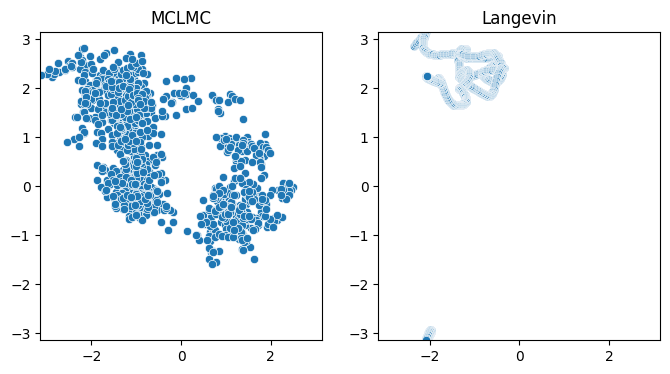

In [ ]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(T=300, dt=2, L_factor=300, chain_length=100000, gamma=1.0)

MCLMC


L:  43.05105679466853
eps:  1.435035226488951
RMS:  10.276860225863517
Energy error:  0.4937610219737243
ESS (via ess_corr):  0.0007664103378610593


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


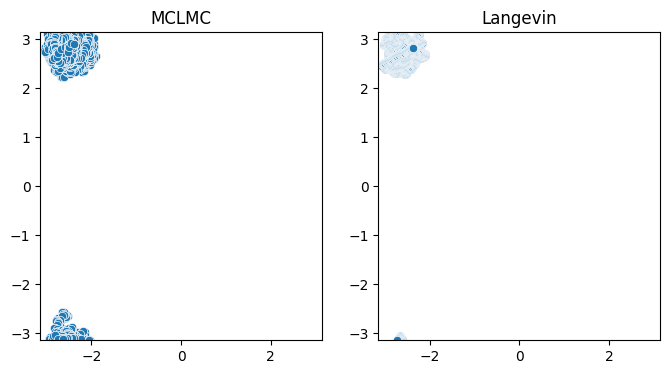

In [104]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=2, L_factor=30, chain_length=10000, gamma=0.1)

MCLMC


L:  21.525528397334266
eps:  0.7175176132444755
RMS:  10.205486528498016
Energy error:  0.09453810991207741
ESS (via ess_corr):  0.006587474172695234


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


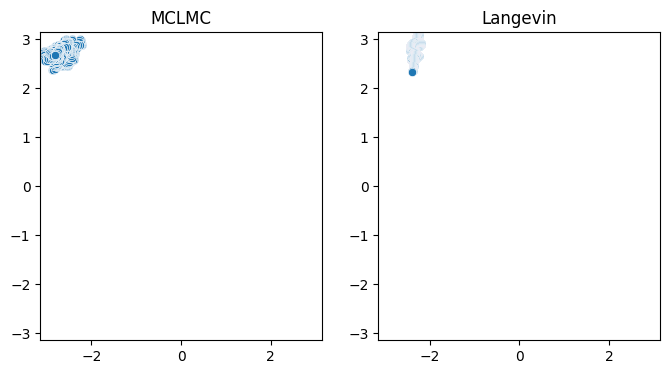

In [105]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=1, L_factor=30, chain_length=1000, gamma=0.1)

MCLMC


L:  430.5105679466853
eps:  1.435035226488951
RMS:  10.232661731939565
Energy error:  0.6193629831802874
ESS (via ess_corr):  0.006004545903955494


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
2023-06-07 13:45:42.054565: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  slice.2402 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
20

Langevin


Gamma:  0.1


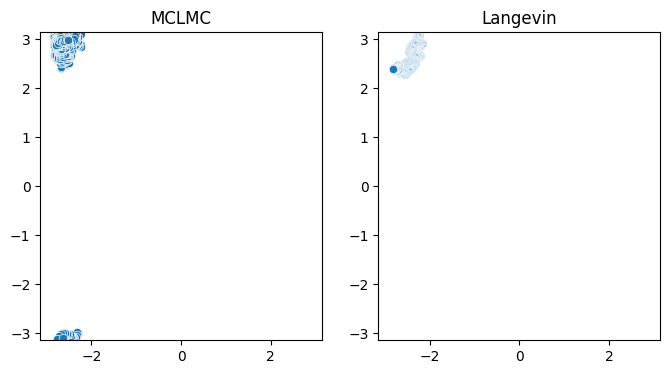

In [106]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=2, L_factor=300, chain_length=1000, gamma=0.1)

MCLMC


L:  172.20422717867413
eps:  5.740140905955804
RMS:  10.115942419726904
Energy error:  40105.04180094439
ESS (via ess_corr):  0.00374402341143413


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


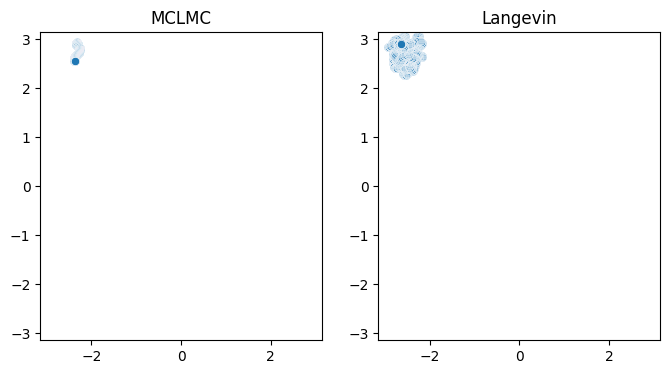

In [107]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(dt=8, L_factor=30, chain_length=1000, gamma=0.1)

# Dataset for system with more solvent

In [108]:
# traj = md.load('/Users/reubencohn-gordon/Downloads/ala2 2/sim4/trajectory.dcd', top='/Users/reubencohn-gordon/Downloads/ala2 2/ala2.pdb')
# angles3 = md.compute_dihedrals(traj, [phi_indices, psi_indices])
# # # unitC = nnp.array([(len(traj)//100)*[nnp.diag(mol.box[:,0])]]).squeeze()

# sns.scatterplot(x = angles3[::1, 0], y = angles3[::1, 1])
# plt.xlim(-math.pi, math.pi)
# plt.ylim(-math.pi, math.pi)

# # trajectory2.xyz.shape